# Training Logistic Regression via Stochastic Gradient Ascent

The goal of this notebook is to implement a logistic regression classifier using stochastic gradient ascent. You will:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with respect to a single coefficient.
 * Implement stochastic gradient ascent.
 * Compare convergence of stochastic gradient ascent with that of batch gradient ascent.

# Fire up GraphLab Create
 
Make sure you have the latest version of GraphLab Create. Upgrade by

```
   pip install graphlab-create --upgrade
```
See [this page](https://dato.com/download/) for detailed instructions on upgrading.

In [41]:
from __future__ import division
import graphlab

## Load and process review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [42]:
products = graphlab.SFrame('amazon_baby_subset.gl/')

Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string manipulation functionality.
2. Compute word counts (only for the important_words)

Refer to Module 3 assignment for more details.

In [43]:
import json
with open('important_words.json', 'r') as f: 
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

# Remote punctuation
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

The SFrame **products** now contains one column for each of the 193 **important_words**. 

In [44]:
products

name,review,rating,sentiment,review_clean,baby
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1,All of my kids have criednonstop when I tried to ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,1,We wanted to getsomething to keep track ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,1,My daughter had her 1stbaby over a year ago She ...,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,1,One of babys first andfavorite books and it is ...,0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,1,Very cute interactivebook My son loves this ...,0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,1,Beautiful book I love itto record cherished t ...,0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,1,Try this out for a springproject Easy fun and ...,0
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5.0,1,very nice Divine MercyPendant of Jesus now on ...,0
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4.0,1,We bought the pins as my6 year old Autistic son ...,0
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5.0,1,It has been many yearssince we needed diaper ...,0


### Split data into training and validation sets

We will now split the data into a 90-10 split where 90% is in the training set and 10% is in the validation set. We use `seed=1` so that everyone gets the same result.

In [45]:
train_data, validation_data = products.random_split(.9, seed=1)

print 'Training set  : %d data points' % len(train_data)
print 'Validation set: %d data points' % len(validation_data)

Training set  : 47780 data points
Validation set: 5292 data points


## Convert SFrame to NumPy array

Just like in the earlier assignments, we provide you with a function that extracts columns from an SFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [46]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

Note that we convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [47]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

**Are you running this notebook on an Amazon EC2 t2.micro instance?** (If you are using your own machine, please skip this section)

It has been reported that t2.micro instances do not provide sufficient power to complete the conversion in acceptable amount of time. For interest of time, please refrain from running `get_numpy_data` function. Instead, download the [binary file](https://s3.amazonaws.com/static.dato.com/files/coursera/course-3/numpy-arrays/module-10-assignment-numpy-arrays.npz) containing the four NumPy arrays you'll need for the assignment. To load the arrays, run the following commands:
```
arrays = np.load('module-10-assignment-numpy-arrays.npz')
feature_matrix_train, sentiment_train = arrays['feature_matrix_train'], arrays['sentiment_train']
feature_matrix_valid, sentiment_valid = arrays['feature_matrix_valid'], arrays['sentiment_valid']
```

** Quiz question**: In Module 3 assignment, there were 194 features (an intercept + one feature for each of the 193 important words). In this assignment, we will use stochastic gradient ascent to train the classifier using logistic regression. How does the changing the solver to stochastic gradient ascent affect the number of features?

## Building on logistic regression

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 


We will use the **same code** as in Module 3 assignment to make probability predictions, since this part is not affected by using stochastic gradient ascent as a solver. Only the way in which the coefficients are learned is affected by using stochastic gradient ascent as a solver.

In [59]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  

    score = np.dot(feature_matrix, coefficients)
  
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1. / (1.+np.exp(-score))    
    return predictions

## Derivative of log likelihood with respect to a single coefficient

Let us now work on making minor changes to how the derivative computation is performed for logistic regression.

Recall from the lectures and Module 3 assignment that for logistic regression, **the derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

In Module 3 assignment, we wrote a function to compute the derivative of log likelihood with respect to a single coefficient $w_j$. The function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 
Complete the following code block:

In [49]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors,feature)

    return derivative

**Note**. We are not using regularization in this assignment, but, as discussed in the optional video, stochastic gradient can also be used for regularized logistic regression.

To verify the correctness of the gradient computation, we provide a function for computing average log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

To track the performance of stochastic gradient ascent, we provide a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

**Note** that we made one tiny modification to the log likelihood function (called **compute_log_likelihood**) in our earlier assignments. We added a $\color{red}{1/N}$ term which averages the log likelihood accross all data points. The $\color{red}{1/N}$ term makes it easier for us to compare stochastic gradient ascent with batch gradient ascent. We will use this function to generate plots that are similar to those you saw in the lecture.

In [50]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):
    
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
    
    return lp

** Quiz Question:** Recall from the lecture and the earlier assignment, the log likelihood (without the averaging term) is given by 

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

How are the functions $\ell\ell(\mathbf{w})$ and $\ell\ell_A(\mathbf{w})$ related?

## Modifying the derivative for stochastic gradient ascent

Recall from the lecture that the gradient for a single data point $\color{red}{\mathbf{x}_i}$ can be computed using the following formula:

$$
\frac{\partial\ell_{\color{red}{i}}(\mathbf{w})}{\partial w_j} = h_j(\color{red}{\mathbf{x}_i})\left(\mathbf{1}[y_\color{red}{i} = +1] - P(y_\color{red}{i} = +1 | \color{red}{\mathbf{x}_i}, \mathbf{w})\right)
$$


** Computing the gradient for a single data point**

Do we really need to re-write all our code to modify $\partial\ell(\mathbf{w})/\partial w_j$ to $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$? 


Thankfully **No!**. Using NumPy, we access $\mathbf{x}_i$ in the training data using `feature_matrix_train[i:i+1,:]`
and $y_i$ in the training data using `sentiment_train[i:i+1]`. We can compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ by re-using **all the code** written in **feature_derivative** and **predict_probability**.


We compute $\partial\ell_{\color{red}{i}}(\mathbf{w})/\partial w_j$ using the following steps:
* First, compute $P(y_i = +1 | \mathbf{x}_i, \mathbf{w})$ using the **predict_probability** function with `feature_matrix_train[i:i+1,:]` as the first parameter.
* Next, compute $\mathbf{1}[y_i = +1]$ using `sentiment_train[i:i+1]`.
* Finally, call the **feature_derivative** function with `feature_matrix_train[i:i+1, j]` as one of the parameters. 

Let us follow these steps for `j = 1` and `i = 10`:

In [95]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions        
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print "Gradient single data point: %s" % gradient_single_data_point
print "           --> Should print 0.0"
print len((feature_matrix_train))

Gradient single data point: 0.0
           --> Should print 0.0
47780


** Quiz Question:** The code block above computed $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$ for `j = 1` and `i = 10`.  Is $\partial\ell_{\color{red}{i}}(\mathbf{w})/{\partial w_j}$ a scalar or a 194-dimensional vector?

## Modifying the derivative for using a batch of data points

Stochastic gradient estimates the ascent direction using 1 data point, while gradient uses $N$ data points to decide how to update the the parameters.  In an optional video, we discussed the details of a simple change that allows us to use a **mini-batch** of $B \leq N$ data points to estimate the ascent direction. This simple approach is faster than regular gradient but less noisy than stochastic gradient that uses only 1 data point. Although we encorage you to watch the optional video on the topic to better understand why mini-batches help stochastic gradient, in this assignment, we will simply use this technique, since the approach is very simple and will improve your results.

Given a mini-batch (or a set of data points) $\mathbf{x}_{i}, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$, the gradient function for this mini-batch of data points is given by:
$$
\color{red}{\sum_{s = i}^{i+B}} \frac{\partial\ell_{s}}{\partial w_j} = \color{red}{\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$


** Computing the gradient for a "mini-batch" of data points**

Using NumPy, we access the points $\mathbf{x}_i, \mathbf{x}_{i+1} \ldots \mathbf{x}_{i+B}$ in the training data using `feature_matrix_train[i:i+B,:]`
and $y_i$ in the training data using `sentiment_train[i:i+B]`. 

We can compute $\color{red}{\sum_{s = i}^{i+B}} \partial\ell_{s}/\partial w_j$ easily as follows:

In [52]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print "Gradient mini-batch data points: %s" % gradient_mini_batch
print "                --> Should print 1.0"

[[1 0 1 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 ..., 
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [1 0 2 ..., 0 0 0]]
Gradient mini-batch data points: 1.0
                --> Should print 1.0


** Quiz Question:** The code block above computed 
$\color{red}{\sum_{s = i}^{i+B}}\partial\ell_{s}(\mathbf{w})/{\partial w_j}$ 
for `j = 10`, `i = 10`, and `B = 10`. Is this a scalar or a 194-dimensional vector?


** Quiz Question:** For what value of `B` is the term
$\color{red}{\sum_{s = 1}^{B}}\partial\ell_{s}(\mathbf{w})/\partial w_j$
the same as the full gradient
$\partial\ell(\mathbf{w})/{\partial w_j}$?


### Averaging the gradient across a batch

It is a common practice to normalize the gradient update rule by the batch size B:

$$
\frac{\partial\ell_{\color{red}{A}}(\mathbf{w})}{\partial w_j} \approx \color{red}{\frac{1}{B}} {\sum_{s = i}^{i + B}} h_j(\mathbf{x}_s)\left(\mathbf{1}[y_s = +1] - P(y_s = +1 | \mathbf{x}_s, \mathbf{w})\right)
$$
In other words, we update the coefficients using the **average gradient over data points** (instead of using a summation). By using the average gradient, we ensure that the magnitude of the gradient is approximately the same for all batch sizes. This way, we can more easily compare various batch sizes of stochastic gradient ascent (including a batch size of **all the data points**), and study the effect of batch size on the algorithm as well as the choice of step size.


## Implementing stochastic gradient ascent

Now we are ready to implement our own logistic regression with stochastic gradient ascent. Complete the following function to fit a logistic regression model using gradient ascent:

In [78]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]
    
    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        ### YOUR CODE HERE
        predictions =  predict_probability(feature_matrix[i:i+batch_size,:], coefficients)
        
        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        ### YOUR CODE HERE
        indicator = (sentiment[i:i+batch_size]==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            ### YOUR CODE HERE
            derivative =  feature_derivative(errors, feature_matrix[i:i+batch_size,j])
            # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
            ### YOUR CODE HERE
    
            coefficients[j] +=  step_size *  derivative * (1./batch_size)
        
        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],
                                        coefficients)
        log_likelihood_all.append(lp)
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print 'Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp)
        
        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

**Note**. In practice, the final set of coefficients is rarely used; it is better to use the average of the last K sets of coefficients instead, where K should be adjusted depending on how fast the log likelihood oscillates around the optimum.

### Checkpoint


The following cell tests your stochastic gradient ascent function using a toy dataset consisting of two data points. If the test does not pass, make sure you are normalizing the gradient update rule correctly.

In [79]:
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3),
                                                  step_size=1., batch_size=2, max_iter=2)
print '-------------------------------------------------------------------------------------'
print 'Coefficients learned                 :', coefficients
print 'Average log likelihood per-iteration :', log_likelihood
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print '-------------------------------------------------------------------------------------'
    print 'Test passed!'
else:
    print '-------------------------------------------------------------------------------------'
    print 'Test failed'

Iteration 0: Average log likelihood (of data points in batch [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points in batch [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


## Compare convergence behavior of stochastic gradient ascent

For the remainder of the assignment, we will compare stochastic gradient ascent against batch gradient ascent. For this, we need a reference implementation of batch gradient ascent. But do we need to implement this from scratch?

**Quiz Question:** For what value of batch size `B` above is the stochastic gradient ascent function **logistic_regression_SG** act as a standard gradient ascent algorithm?

## Running gradient ascent using the stochastic gradient ascent implementation

Instead of implementing batch gradient ascent separately, we save time by re-using the stochastic gradient ascent function we just wrote &mdash; **to perform gradient ascent**, it suffices to set **`batch_size`** to the number of data points in the training data. Yes, we did answer above the quiz question for you, but that is an important point to remember in the future :)

**Small Caveat**. The batch gradient ascent implementation here is slightly different than the one in the earlier assignments, as we now normalize the gradient update rule.

We now **run stochastic gradient ascent** over the **feature_matrix_train** for 10 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = 1`
* `max_iter = 10`

In [80]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points in batch [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points in batch [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points in batch [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points in batch [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points in batch [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points in batch [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points in batch [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points in batch [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points in batch [00009:00010]) = -0.00000124


**Quiz Question**. When you set `batch_size = 1`, as each iteration passes, how does the average log likelihood in the batch change?
* Increases
* Decreases
* Fluctuates 

Now run **batch gradient ascent** over the **feature_matrix_train** for 200 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = len(feature_matrix_train)`
* `max_iter = 200`

In [82]:
# YOUR CODE HERE
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                        initial_coefficients=np.zeros(194),
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=10)

Iteration 0: Average log likelihood (of data points in batch [00000:47780]) = -0.68308119
Iteration 1: Average log likelihood (of data points in batch [00000:47780]) = -0.67394599
Iteration 2: Average log likelihood (of data points in batch [00000:47780]) = -0.66555129
Iteration 3: Average log likelihood (of data points in batch [00000:47780]) = -0.65779626
Iteration 4: Average log likelihood (of data points in batch [00000:47780]) = -0.65060701
Iteration 5: Average log likelihood (of data points in batch [00000:47780]) = -0.64392241
Iteration 6: Average log likelihood (of data points in batch [00000:47780]) = -0.63769009
Iteration 7: Average log likelihood (of data points in batch [00000:47780]) = -0.63186462
Iteration 8: Average log likelihood (of data points in batch [00000:47780]) = -0.62640636
Iteration 9: Average log likelihood (of data points in batch [00000:47780]) = -0.62128063


**Quiz Question**. When you set `batch_size = len(train_data)`, as each iteration passes, how does the average log likelihood in the batch change?
* Increases 
* Decreases
* Fluctuates 

## Make "passes" over the dataset

To make a fair comparison betweeen stochastic gradient ascent and batch gradient ascent, we measure the average log likelihood as a function of the number of passes (defined as follows):
$$
[\text{# of passes}] = \frac{[\text{# of data points touched so far}]}{[\text{size of dataset}]}
$$

**Quiz Question** Suppose that we run stochastic gradient ascent with a batch size of 100. How many gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points?

In [83]:
print 1000

1000


## Log likelihood plots for stochastic gradient ascent

With the terminology in mind, let us run stochastic gradient ascent for 10 passes. We will use
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [84]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points in batch [01000

We provide you with a utility function to plot the average log likelihood as a function of the number of passes.

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

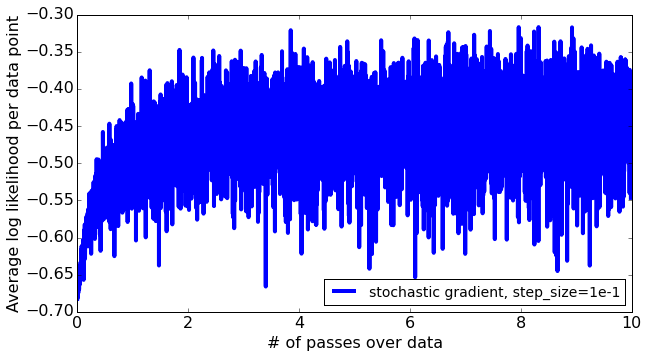

In [86]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

## Smoothing the stochastic gradient ascent curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. In our plot, we apply a simple smoothing operation using the parameter `smoothing_window`. The smoothing is simply a [moving average](https://en.wikipedia.org/wiki/Moving_average) of log likelihood over the last `smoothing_window` "iterations" of  stochastic gradient ascent.

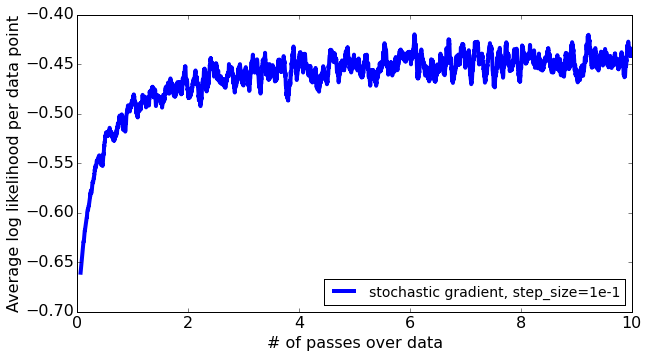

In [87]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

**Checkpoint**: The above plot should look smoother than the previous plot. Play around with `smoothing_window`. As you increase it, you should see a smoother plot.

## Stochastic gradient ascent vs batch gradient ascent

To compare convergence rates for stochastic gradient ascent with batch gradient ascent, we call `make_plot()` multiple times in the same cell.

We are comparing:
* **stochastic gradient ascent**: `step_size = 0.1`, `batch_size=100`
* **batch gradient ascent**: `step_size = 0.5`, `batch_size=len(feature_matrix_train)`

Write code to run stochastic gradient ascent for 200 passes using:
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [88]:
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points in batch [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points in batch [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points in batch [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points in batch [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points in batch [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points in batch [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points in batch [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points in batch [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points in batch [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points in batch [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points in b

We compare the convergence of stochastic gradient ascent and batch gradient ascent in the following cell. Note that we apply smoothing with `smoothing_window=30`.

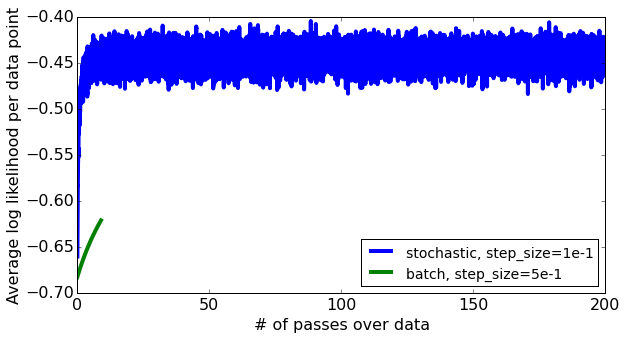

In [89]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

**Quiz Question**: In the figure above, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent? 

1. It's always better
2. 10 passes
3. 20 passes
4. 150 passes or more

## Explore the effects of step sizes on stochastic gradient ascent

In previous sections, we chose step sizes for you. In practice, it helps to know how to choose good step sizes yourself.

To start, we explore a wide range of step sizes that are equally spaced in the log space. Run stochastic gradient ascent with `step_size` set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2. Use the following set of parameters:
* `initial_coefficients=np.zeros(194)`
* `batch_size=100`
* `max_iter` initialized so as to run 10 passes over the data.

In [91]:
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=step_size, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points in batch [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points in batch [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points in batch [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points in batch [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points in batch [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points in batch [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points in batch [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points in batch [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points in batch [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points in batch [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points in batch [01000

### Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the `make_plot` for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

For consistency, we again apply `smoothing_window=30`.

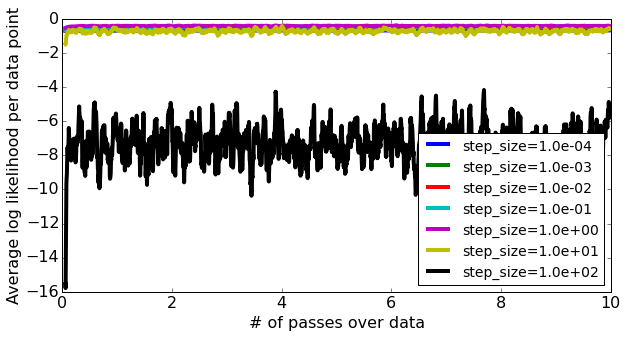

In [92]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

Now, let us remove the step size `step_size = 1e2` and plot the rest of the curves.

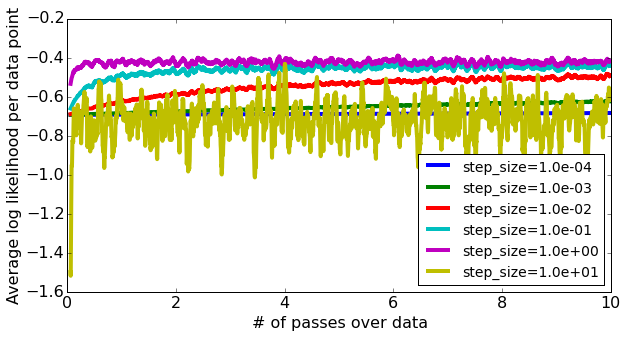

In [93]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

**Quiz Question**: Which of the following is the worst step size? Pick the step size that results in the lowest log likelihood in the end.
1. 1e-2
2. 1e-1
3. 1e0
4. 1e1
5. 1e2

**Quiz Question**: Which of the following is the best step size? Pick the step size that results in the highest log likelihood in the end.
1. 1e-4
2. 1e-2
3. 1e0
4. 1e1
5. 1e2